In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreadr
import yaml
from os.path import join
from datetime import datetime

%matplotlib inline

In [2]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']

In [3]:
FIG_SAVE_DIR = join(pwd, 'figures')

In [4]:
result = pyreadr.read_r(join(pwd, dpath, 'COVID-19.rds'))

In [5]:
df = result[None]
df = df[(df.ID.str.len() > 7) & (df.ID.str.startswith('US')) & (df.Type == 'Confirmed') & (df.Source == 'NYC')]

# NYC county fips codes
codes = set(['36085', '36081', '36061', '36047', '36005'])

def check_county(fips):
    c = fips[2:7]
    return c in codes

def get_zcta(fips):
    return fips[-5:]

df = df[df.ID.apply(check_county)]
df.ID = df.ID.apply(get_zcta)
df.Date = pd.to_datetime(df.Date)
df['Cases_New'] = pd.to_numeric(df['Cases_New'])
df = df[~df.ID.str.startswith('0')]
df['Cases_New'] = df['Cases_New'].clip(0)

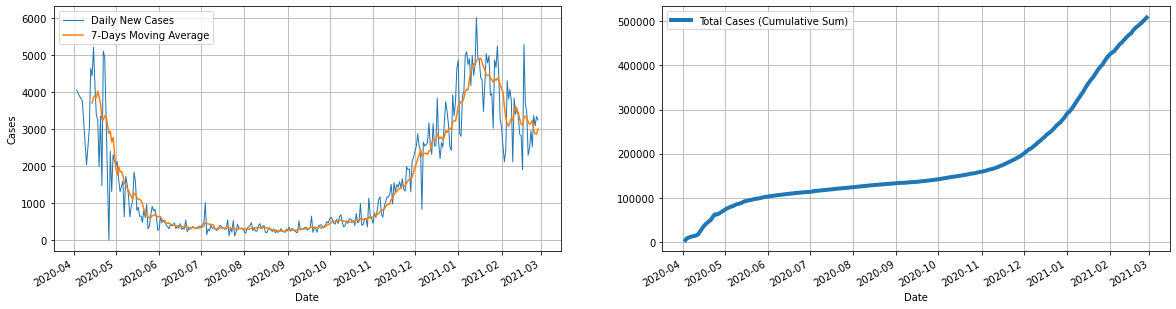

In [11]:
date_groups = df.groupby('Date').sum()['Cases_New'].sort_index()
# removing irregular entries
date_groups = date_groups[date_groups < 10**3 * 7]

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 5))

date_groups.plot(ax=ax[0], label='Daily New Cases', linewidth=1)
date_groups.rolling(window=7).mean().plot(ax=ax[0], label='7-Days Moving Average')
#date_groups.cumsum().plot(ax=ax[1])
date_groups.cumsum().plot(ax=ax[1], linewidth=4, label='Total Cases (Cumulative Sum)')

ax[0].grid()
ax[0].set_ylabel('Cases')
ax[0].legend()
ax[1].grid()
ax[1].legend()

fig.savefig(join(FIG_SAVE_DIR, 'covid-nyc-daily-case.png'))

In [8]:
sel_dates = df[df.Date.isin(date_groups.index)]
res = sel_dates.groupby(['ID', pd.Grouper(key='Date', freq='W-MON')])[['Cases_New']].sum().reset_index().sort_values('Date')
res.Date = res.Date - pd.to_timedelta(7, unit='d')
res.to_csv(join(pwd, 'util_datasets', 'nyc-weekly-cases.csv'), index=False)